In [1]:
%pylab inline
import logging
logging.disable(logging.CRITICAL) # hush some notebook warnings

Populating the interactive namespace from numpy and matplotlib


# LDA, MRR, & YOU

[Mean reciprocol rank][MRR] is a common way in which we evaluate search-based tools. It's fairly straightforward:

$$\text{MRR} = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \frac{1}{\text{rank}_i}.$$

Where $Q$ is the test query set and $rank_i$ the rank of the first relevant result. In the end, an MRR of 1.0 is perfect (i.e., the correct answer is always returned top of the list), and 0.0 a very hard thing to achieve (i.e., you would need to be returning an infinitely long list).

[MRR]: https://en.wikipedia.org/wiki/Mean_reciprocal_rank

Here's an MRR in Python:

In [2]:
import numpy

def calculate_mrr(p):
    return numpy.mean( 1.0/ numpy.array(p) )

In general, this thing works fine for information retrieval (IR) tasks because $Q$ is sufficiently large or the IR technique is deterministic. However, when using a stochastic-based model, such as [latent Dirichlet allocation][LDA] (LDA), this is no longer as useful if $Q$ isn't large. 

In software engineering research, this is especially true: we typically have a small goldset to test on per software system. However, we also have a deeper, secondary problem when using LDA: we use a software system's artifacts (i.e., source code files). This means we are giving LDA a low number of documents.

What I am to show you here is how to design better experiments that rely on LDA. Let's get started, shall we?

[LDA]: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

In [3]:
import pandas
from gensim.corpora import MalletCorpus, Dictionary
from gensim.models import LdaModel
from gensim.similarities import MatrixSimilarity
from gensim.matutils import cossim
import src
from operator import itemgetter
import pickle

First, let's load up some test data. I've already prepared the data necessary:

In [6]:
dictionary = Dictionary.load('data/tika/v1.8/SnapshotCorpus-file.dict.gz')
corpus = MalletCorpus('data/tika/v1.8/SnapshotCorpus-file.mallet.gz', id2word=dictionary)
queries = MalletCorpus('data/tika/v1.8/Queries.mallet.gz', id2word=dictionary)

In [7]:
len(dictionary), len(corpus), len(queries)

(54116, 954, 40)

So, my chosen subject system, Tika v1.8, has 54116 words in it's corpus of 954 files and I'd like to test it's feature location performance over 40 queries. Let's create an LDA model of this:

In [10]:
model = LdaModel(corpus=corpus, 
                 id2word=dictionary, 
                 decay=0,  # Kappa
                 chunksize=len(corpus), # S
                )
                 #max_bound_iterations=100) # upper limit on batch VB algo

And now, get an index for each document's topic distribution:

In [11]:
corpus_topics = model[corpus]
sims = MatrixSimilarity(corpus_topics, num_features=model.num_topics)

In [21]:
corpus_topics[0]

[(15, 0.65554831952887471), (93, 0.32267390269334517)]

And the queries:

In [12]:
query_topics = model[queries]

Next in our quest, we want to find out which documents are most similar to a query, say query #0:

In [13]:
sims[query_topics[0]]

array([ 0.        ,  0.        ,  0.12220822,  0.        ,  0.        ,
        0.00182169,  0.08989681,  0.00398154,  0.        ,  0.13306949,
        0.12829663,  0.        ,  0.09444789,  0.        ,  0.6801942 ,
        0.23366705,  0.01532279,  0.        ,  0.        ,  0.03612027,
        0.        ,  0.        ,  0.48004574,  0.19207229,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.59166849,  0.        ,  0.        ,  0.00761924,
        0.        ,  0.01798488,  0.13820371,  0.28818786,  0.        ,
        0.        ,  0.        ,  0.        ,  0.13872808,  0.        ,
        0.        ,  0.        ,  0.20053922,  0.        ,  0.        ,
        0.        ,  0.02372311,  0.00553298,  0.        ,  0.20953514,
        0.2017334 ,  0.03606002,  0.        ,  0.23998713,  0.        ,
        0.        ,  0.        ,  0.        ,  0.54270321,  0.68814778,
        0.1936769 ,  0.        ,  0.        ,  0.06338858,  0.47

Well, that's certainly *unreadable*.

In [14]:
sorted(enumerate(sims[query_topics[0]]), key=itemgetter(1), reverse=True)[:15]

[(214, 0.85729897),
 (798, 0.85729897),
 (292, 0.85690576),
 (561, 0.85636199),
 (324, 0.85628319),
 (252, 0.84514654),
 (245, 0.83830184),
 (80, 0.8358677),
 (153, 0.82815647),
 (423, 0.82569611),
 (278, 0.8256219),
 (596, 0.82173121),
 (393, 0.81696939),
 (190, 0.81657869),
 (254, 0.8101005)]

Much better. So document #559 of the corpus is the one most similar to query #0. Neat.

Here, if #559 was the correct document for query #0, it would have an $MRR=1.0$, because it is rank 1. However, if it were that #917 most related to the query, it would be $1/9$ because #917 is the 9th rank.

In [15]:
with open('pickles/tikav1.8.pkl', 'rb') as f:
    goldsets = pickle.load(f)

In [33]:
goldsets[0]

{2, 917}

In [17]:
all_ranks = dict()
for query_id, goldset in goldsets.items():
    results = sims[query_topics[query_id]]
    ranks = list()
    for doc_id in goldset:
        rank = sum(1 for x in results if x >= results[doc_id])
        ranks.append((rank, doc_id, results[doc_id]))
    all_ranks[query_id] = sorted(ranks)

In [18]:
all_ranks[0]

[(2, 917, 0.8891989), (250, 2, 0.12267691)]

In [37]:
first_relevant = [r for r, _, _ in [min(ranks) for ranks in all_ranks.values()]]
first_relevant

[2,
 20,
 47,
 1,
 54,
 2,
 19,
 20,
 1,
 9,
 73,
 35,
 42,
 954,
 284,
 250,
 135,
 954,
 10,
 135,
 136,
 142,
 16,
 83,
 30,
 3,
 16,
 84,
 60,
 29,
 7,
 2,
 22,
 14,
 382,
 65,
 361,
 118,
 954,
 195]

In [20]:
calculate_mrr([rank for rank, _, _ in first_relevant])

0.12175944411260979

# So what? Get to the point.

The point is the following. Let's say we have a model built, like we do above. Each time we query it, we can potentially get different results:



In [22]:
def get_mrr(model, sims, queries, goldsets):
    query_topics = model[queries]
    all_ranks = dict()
    for query_id, goldset in goldsets.items():
        results = sims[query_topics[query_id]]
        ranks = list()
        for doc_id in goldset:
            rank = sum(1 for x in results if x >= results[doc_id])
            ranks.append((rank, doc_id, results[doc_id]))
        all_ranks[query_id] = sorted(ranks)
    first_relevant = [min(ranks) for ranks in all_ranks.values()]
    return calculate_mrr([rank for rank, _, _ in first_relevant])

In [31]:
get_mrr(model, sims, queries, goldsets)

0.12072114189621612

count    100.000000
mean       0.117222
std        0.009489
min        0.090311
25%        0.110917
50%        0.120743
75%        0.122682
max        0.147086
dtype: float64


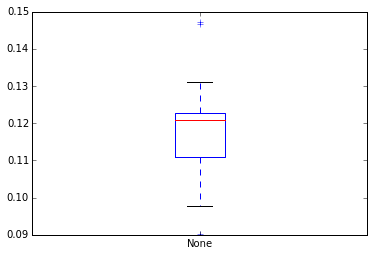

In [24]:
s1 = pandas.Series(get_mrr(model, sims, queries, goldsets) for _ in range(100))
print(s1.describe())
s1.plot(kind='box')

# 40 queries is not enough to accurately judge something

So, what do we do? Run LDA 1000 times, take some average of all the MRRs? Well, that would certainly take a lot of time.

How about we try to artificially increase the number queries by just doing the query phase multiple times?

In [115]:
def get_mrr(runs, model, sims, queries, goldsets):
    first_relevant = list()
    for run in range(runs):
        query_topics = model[queries]
        all_ranks = dict()
        for query_id, goldset in goldsets.items():
            results = sims[query_topics[query_id]]
            ranks = list()
            for doc_id in goldset:
                rank = sum(1 for x in results if x >= results[doc_id])
                ranks.append((rank, doc_id, results[doc_id]))
            all_ranks[query_id] = sorted(ranks)
        first_relevant.extend(min(ranks) for ranks in all_ranks.values())
    return calculate_mrr([rank for rank, _, _ in first_relevant])

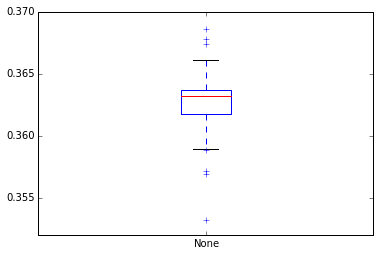

In [ ]:
s5 = pandas.Series(get_mrr(5, model, sims, queries, goldsets) for _ in range(100))
s5.plot(kind='box')

In [ ]:
s10 = pandas.Series(get_mrr(10, model, sims, queries, goldsets) for _ in range(100))
s50 = pandas.Series(get_mrr(50, model, sims, queries, goldsets) for _ in range(100))
s100 = pandas.Series(get_mrr(100, model, sims, queries, goldsets) for _ in range(100))

In [ ]:
df = pandas.DataFrame({1: s1, 5: s5, 10: s10, 50: s50, 100: s100})
df.plot(kind='box')

In [ ]:
def run_itttttt(name, version, runs):
    dictionary = Dictionary.load('data/%s/%s/SnapshotCorpusfile.dict.gz' % (name, version))
    corpus = MalletCorpus('data/%s/%s/SnapshotCorpusfile.mallet.gz' % (name, version), id2word=dictionary)
    queries = MalletCorpus('data/%s/%s/Queries.mallet.gz' % (name, version), id2word=dictionary)
    print("Dictionary:", len(dictionary))
    print("Corpus:", len(corpus))
    print("Queries:", len(queries))

    with open('pickles/'+name+version+'.pkl', 'rb') as f:
        goldsets = pickle.load(f)
    
    df = pandas.DataFrame()
    for i in range(runs):
        model = LdaModel(corpus=corpus, 
                 id2word=dictionary, 
                 decay=0,  # Kappa
                 chunksize=len(corpus), # S
                 max_em_iterations=100) # upper limit on batch VB algo
        corpus_topics = model[corpus]
        sims = MatrixSimilarity(corpus_topics, num_features=model.num_topics)

        df[i] = pandas.Series(get_mrr(1, model, sims, queries, goldsets) for _ in range(100))
        
    print(df.describe())
    df.plot(kind='box')

('Dictionary:', 54116)
('Corpus:', 954)
('Queries:', 40)
                0           1           2           3           4
count  100.000000  100.000000  100.000000  100.000000  100.000000
mean     0.133500    0.124329    0.143798    0.191651    0.218325
std      0.007010    0.013122    0.013689    0.004914    0.010094
min      0.102039    0.099302    0.112044    0.173926    0.193445
25%      0.133274    0.110629    0.138045    0.188635    0.211156
50%      0.134700    0.128379    0.139391    0.192613    0.221111
75%      0.136650    0.133565    0.158670    0.194645    0.223341
max      0.158957    0.148885    0.167122    0.203129    0.246125


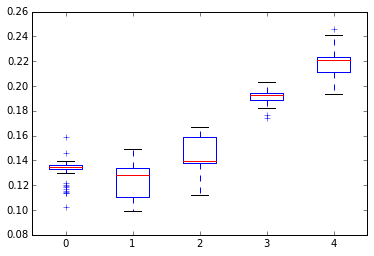

In [212]:
run_itttttt('tika', 'v1.8', 5)

('Dictionary:', 14553)
('Corpus:', 2098)
('Queries:', 222)
                0           1           2           3           4
count  100.000000  100.000000  100.000000  100.000000  100.000000
mean     0.111949    0.117205    0.092590    0.110905    0.206711
std      0.004432    0.004380    0.005675    0.002845    0.004313
min      0.101173    0.109594    0.081192    0.104019    0.196130
25%      0.108398    0.113426    0.088496    0.108529    0.203888
50%      0.112094    0.116854    0.093035    0.110731    0.207090
75%      0.114848    0.119762    0.095679    0.112901    0.209598
max      0.125677    0.128380    0.108906    0.118552    0.217216


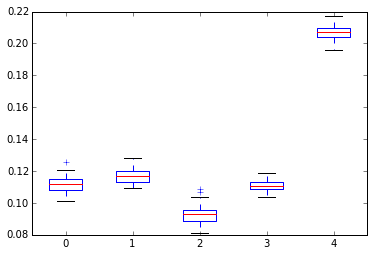

In [213]:
run_itttttt('pig', 'v0.14.0', 5)

('Dictionary:', 6003)
('Corpus:', 843)
('Queries:', 164)
                0           1           2           3           4
count  100.000000  100.000000  100.000000  100.000000  100.000000
mean     0.203606    0.197098    0.224751    0.188762    0.230394
std      0.005646    0.007751    0.009850    0.005243    0.006357
min      0.187533    0.175519    0.204545    0.175430    0.214569
25%      0.200254    0.191570    0.218442    0.185314    0.226513
50%      0.202610    0.197932    0.224588    0.189185    0.230061
75%      0.207011    0.202072    0.230950    0.191680    0.234195
max      0.217414    0.214740    0.248735    0.204630    0.245217


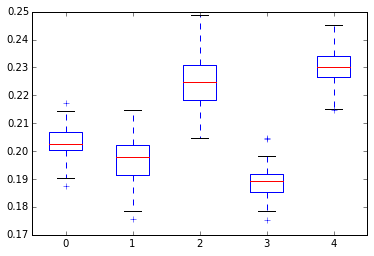

In [214]:
run_itttttt('bookkeeper', 'v4.3.0', 5)

('Dictionary:', 20508)
('Corpus:', 1573)
('Queries:', 133)
                0           1           2           3           4
count  100.000000  100.000000  100.000000  100.000000  100.000000
mean     0.254512    0.079902    0.132039    0.129619    0.113957
std      0.008982    0.005646    0.006031    0.003529    0.009187
min      0.234477    0.068351    0.114785    0.120039    0.088228
25%      0.249304    0.075328    0.127867    0.127524    0.107322
50%      0.254619    0.080456    0.131132    0.129955    0.114176
75%      0.260752    0.083153    0.136401    0.131930    0.120668
max      0.279684    0.093774    0.146440    0.140861    0.133135


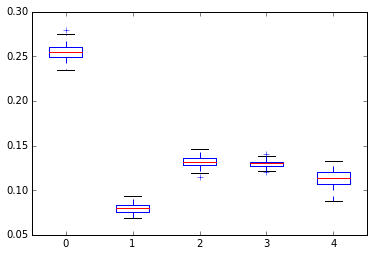

In [215]:
run_itttttt('mahout', 'v0.10.0', 5)

In [216]:
run_itttttt('derby', 'v10.11.1.1', 5)

('Dictionary:', 36951)
('Corpus:', 4344)
('Queries:', 308)


KeyboardInterrupt: 

# So, MRR must be pretty bad, huh. Guess we should be using *< insert my favorite measurement >*, afterall.

No, not necessarily. MRR is a pretty good metric. What we have here is a problem that spawns from two things:

1. Small goldsets
2. Small datasets

The small goldsets means that we do not accurately capture the real MRR. We can try to fix this by artificially increasing the goldset size by some arbitrary number.

However, the problem is worse: because of the small dataset (i.e., low number of documents), LDA gets "stuck". And, across multiple runs, it can get stuck in different places (as just previously shown). This will lead to it recommending very different ranked lists for each query. Hence, using LDA means that ***any ranked-based measurement will inheritly be inaccurate without multiple trials***.

So, it seems like our best option here is to run the entire experiment multiple times. I think it's safe to assume that *any* software engineering results you see using LDA without multiple runs henceforth has been directly influenced by the authors re-running the experiment until it works out in their favor. Full disclosure: I've done it, and discovering that I could do it is why I decided to write this blog post.

In [ ]:
"""
    queries.metadata = True
    corpus.metadata = True
    q2id = dict([(x[1][0], i) for i, x in enumerate(queries)])
    c2id = dict([(x[1][0], i) for i, x in enumerate(corpus)])
    p = [x for x in src.common.load_projects({'level': 'file'}) if x.name == name and x.version == version][0]
    goldsets_full = src.feature_location.create_goldsets(p)
    goldsets = dict()
    for qid, gs in goldsets_full.items():
        goldsets[q2id[qid]] = set(c2id[x] for x in gs if x in c2id)
    queries.metadata = False
    corpus.metadata = False
    with open('pickles/'+name+version+'.pkl', 'wb') as f:
        pickle.dump(goldsets, f)
"""